# Završni rad - Predviđanje starosti korištenjem neuronskih mreža (dio 1/2)

U sklopu ovog završnog rada i 2 Jupyter bilježnice bavit ćemo se predviđanje starosti korištenjem neuronskih mreža. Bilježnice su podijeljene po poglavljima te je svako poglavlje komentirano. 

U ovoj bilježnici na početku je prikazano učitavanje i obrada ulaznih podataka. \
Korišten je set podataka u kojem je na svakoj slici lice neke osobe. Sve slike su poravnate i jednake veličine (200x200 piksela). \
Za svaku sliku u nazivu je dana oznaka godina u obliku: nekiBroj_godinaRodenja_nekiBroj-nekiBroj_godinaSlikanja npr. 23006_1974-04-28_2011. Drugačije označene slike nisu bile obrađene. 

Sama obrada se sastojala od podjele seta na train/val/test setove, normalizacija i augmentacija.

Nakon toga implementirana su dva modela nadziranog učenja: klasifikacijski i regresijski.\
Modeli su testirani na testnom skupu podataka te su dobiveni rezultati prikazani brojčano i grafički. 

## 0. Importi

In [178]:
import numpy as np              
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import os                       
import cv2                      
from PIL import Image
from collections import Counter
import time
import shutil
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import keras

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPool2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import LayerNormalization
from keras.layers import Dropout
from keras.models import Sequential  
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.layers import RandomBrightness

import json
import tempfile

## 1. Podjela seta na train/val/test

U ovom dijelu podijelit ćemo ulazni set podataka na 3 skupa, train, val i test. 
Jednom napravljene podjele spremaju se u .npy file-ove na disku u folder koji je prethodno stvoren pod nazivom 'save_splits_root_path'. 

Kod ponovnog pokretanja programa već generirani setovi samo će se učitati s diska. 

X-evi sadrže slike a y-oni brojčane vrijednosti godina osoba sa slika. 

In [115]:
# putanja do direktorija gdje ce se spremiti .npy fajlovi
save_splits_root_path = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/npyFiles/UTKFace_splits'  

# pathovi za sve splitove; npr. za X_train, path ce biti '/putanja/do/foldera/X_train.npy'
X_train_path, X_val_path, X_test_path = [os.path.join(save_splits_root_path, f'X_{split}.npy') for split in ['train', 'val', 'test']]
y_train_path, y_val_path, y_test_path = [os.path.join(save_splits_root_path, f'y_{split}.npy') for split in ['train', 'val', 'test']]


## ovaj "if" dio ce se izvrsiti samo kad vec postoje pohranjeni X_train, y_train, X_val, ... ;; kad se prvi put pokrece program, izvrsit ce se "else" dio
if os.path.isfile(X_train_path) and os.path.isfile(X_val_path) and os.path.isfile(X_test_path) and os.path.isfile(y_train_path) and os.path.isfile(y_val_path) and os.path.isfile(y_test_path):
    print('loading cached...')
    
    X_train = np.load(X_train_path)
    y_train = np.load(y_train_path)
    
    X_val = np.load(X_val_path)
    y_val = np.load(y_val_path)
    
    X_test = np.load(X_test_path)
    y_test = np.load(y_test_path)
    
    print('...done')
    
else:
    print('creating splits...')
    
    utkDir = Path("/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/UTKFace")
    filepaths_utk = list(utkDir.glob(r'*.jpg'))

    # ucitavanje godina u listu
    ages = []
    for img in filepaths_utk:
        filename = os.path.split(img)[1]
        if (filename == ".DS_Store"):
            continue
        broj_god = int(filename.split('.')[0].split('_')[0])
        ages.append(broj_god)

    # ucitavanje slika u listu
    images = list()
    for path in filepaths_utk:
        image = Image.open(path)
        data = np.asarray(image)
        images.append(data)
    images = np.array(images)

    # pretvaranje lista u np arrayeve
    X = np.array(images)
    y = np.array(ages)

    # splittanje dataseta
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    
    # brisanje X i y da ne zauzimaju memoriju jer vise ne trebaju (svi podaci su u X_train, y_train, X_test, y_test)
    del X
    del y
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11111111111, random_state=42, shuffle=True)
    del X_trainval
    del y_trainval
    
    # spremanje splitova u odgovarajuce pathove
    np.save(X_train_path, X_train)
    np.save(y_train_path, y_train)
    np.save(X_val_path, X_val)
    np.save(y_val_path, y_val)
    np.save(X_test_path, X_test)
    np.save(y_test_path, y_test)
    
    print('...done')


loading cached...
...done


## 2. Normalizacija slika

Normalizaciju radimo na način da mean bude blizu 0, a stddev blizu 1. Mean i stddev se određuju pomoću train seta tako da tražimo mean i stddev svih piksela u train setu te pomoću njih normaliziramo sva 3 skupa. 

Jednom kada se izračunaju mean i stddev svi pikseli traina, vala i testa normaliziraju se s njima pomoću formule:
`X = (X - mean) / stddev`

Koristimo parametar axis=(0,1,2) kako bi dobili mean i stddev po prva 3 kanala.
Izlazi su dva tenzora dimenzije (3,) gdje svaki tenzor ima jednu vrijednost za svaki od kanala (R,G,B).

In [116]:
rgb_mean, rgb_stddev = None, None

# racunanje mean i stddev statistika na train setu
if rgb_mean is None:
    print('calculating mean on train...')
    rgb_mean = X_train.mean(axis=(0,1,2))
    
if rgb_stddev is None:
    print('calculating stddev on train...')
    rgb_stddev = X_train.std(axis=(0,1,2))

print(f'train_mean: {rgb_mean}')
print(f'train_stddev: {rgb_stddev}')

calculating mean on train...
calculating stddev on train...
train_mean: [151.96765842 116.3571425   99.64196383]
train_stddev: [66.13838393 59.0263062  57.8964712 ]


### Normalization layer
Za implementaciju normalizacije koristili smo Kerasov Normalization layer koji ćemo kasnije dodati u naše modele.

In [8]:
normalization = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=rgb_mean, variance=(rgb_stddev ** 2))
])

2022-06-06 20:15:10.688329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Augmentacija slika

Pojam "augmentacija" podrazumijeva bilo kakvu nasumičnu transformaciju slike za koju znamo da će rezultirati slikom koja ne mijenja semantiku ulazne slike. 

Augmentacije koristimo jer se njima umjetno povećava skup za učenje. Svaka slika u svakoj epohi pojavi se malo varirana. Nasumičnim varijacijama postigne se otpornost neuronske mreže na takve varijacije.

Konkretno, augmentacije koje ćemo koristiti su:
- **nasumično horizontalno zrcaljenje slike (50% vjerojatnost)** 
- **nasumično maleno variranje svjetline slike** 
- **nasumično maleno variranje kontrasta slike** 

Za svaku od slika u datasetu, model će vidjeti onoliko njenih nasumičnih varijacija koliko ima epoha.

Augmentacije se uvijek rade samo na train setu a mijenja se samo slika (X) dok labela (y) ostaje nepromijenjena.

Za implementaciju augmentacije koristit ćemo postojeće Kerasove slojeve `RandomFlip, RandomBrightness, RandomContrast` koje ćemo dodati u modele. 

In [117]:
# augmentacije koje koristimo: nasumično horizontalno flippanje slike, nasumično variranje brightnessa, nasumično variranje kontrasta
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomBrightness(factor=0.15, value_range=(0, 255)),
    RandomContrast(factor=0.15)
])

## 4. Priprema setova 

Pretvaramo np array-eve u tf.Dataset objekte jer su oni prikladniji tip podataka kada koristimo Keras tj. Tenserflow. 

In [118]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Pomoću funckije _prepare_dataset_ na ulazni set slika primjenjujemo augmentaciju, normalizaciju i nasumičan odabir. 

In [119]:
def prepare_dataset(ds, batch_size, normalization, data_augmentation=None, shuffle=False, augment=False):
    AUTOTUNE = tf.data.AUTOTUNE   

    # augmentacija podataka samo za train set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # normaliziranje svih podatke
    ds = ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

    # shuffle se za train set
    if shuffle:
        N = len(ds)  # za parametar buffer_size za shuffleanje, nije previse bitno zasad
        ds = ds.shuffle(N)

    # postavljanje batch sizea u datasetu
    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)  

Pozivamo funkciju _prepare_dataset_ za svaki od 3 skupa. \
Nad train setom želimo raditi i augmentaciju, normalizaciju i nasumičan odabir pa predajemo sve parametre. \
Nad val & test setovima ne želimo raditi augmentaciju i nasumičan odabir pa ta dva parametra ne predajemo, a parametar za normalizaciju predajmo. 

In [120]:
# za train set se predaje agumentacija te zastavice za shuffle i augment su True
train_dataset = prepare_dataset(train_dataset, 32, normalization, data_augmentation=data_augmentation, shuffle=True, augment=True)

# za val i test set nema augmentacije te zastavice za shuffle i augment su False
val_dataset = prepare_dataset(val_dataset, 32, normalization)
test_dataset = prepare_dataset(test_dataset, 32, normalization)

## 5. (L2) Regularizacija težina modela

Funkcija _add_regularization_ regularizira matrice težina modela tj. parametre koje modeli uče tokom učenja. To radi na način da kažnjava njihovu L2 normu. Uvodi se dodatna funkcija loss koja je veća ako su vrijednosti težina veće te se u tom slučaju one kažnjavaju kako bi težine modela ostale što manje. 

Ovo nam pomaže da model ne bude prenaučen te da bolje generalizira. 

L2 regularizacija dodaje se svakom sloju s težinama.

In [121]:
def add_regularization(model, regularizer=tf.keras.regularizers.l2(5e-5)):
    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # treba reloadati model jer se nasa promijena zasad manifestira samo u configu modela
    model_json = model.to_json()

    # pohranimo tezine modela da ga mozemo reloadati kakav je bio
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # loadanje modela iz configa
    model = tf.keras.models.model_from_json(model_json)
    
    # loadanje pohranjenih tezina
    model.load_weights(tmp_weights_path, by_name=True)
    
    return model

## 6. Definiranje funkcija za spremanje i učitavanje modela

Pomoću ove dvije funkcije model s najboljim rezultatima spremamo na disk. 

- **save_model** prima model koji se želi pohraniti i putanje za pohranjivanje težina (weights_path - ekstenzija najčešće ".h5") i konfiguracije modela (config_path - ekstenzija ".json")

- **load_model** prima samo putanje na kojima su pohranjene težine i konfiguracija te vraća učitani model

In [122]:
def save_model(model, weights_path, config_path):
    
    # spremanje configa
    model_json = model.to_json()
    with open(config_path, 'w') as f:
        json.dump(model_json, f)

    # spremanje tezina
    model.save_weights(weights_path)

    
def load_model(weights_path, config_path):
    
    # loadanje modela iz configa
    with open(config_path, 'r') as f:
        model_json = json.load(f)
    model = tf.keras.models.model_from_json(model_json)
    
    # ucitavanje tezina
    model.load_weights(weights_path, by_name=True)

## 7. Učenje, evaluacija i spremanje regresijskog modela

U narednim ćelijama regresijski model se definira, uči, evaluira i pohranjuje na disk.

### Izgradnja modela za regresiju  

In [148]:
model = Sequential()

model.add(Conv2D(input_shape=(200, 200, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.1)) 

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.1))  

model.add(Dense(units=1)) # izlaz je 1 brojcana vrijednost 

model.summary()


# zaustavljamo model ako nakon vise od 7 epoha val_mean_absolute_error ne bude padajuca funckija
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=7, restore_best_weights=True, mode='min')

# smanjujemo stopu ucenja kada se val_mean_absolute_error prestane poboljsavati
reduce_lr_callback = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=2, verbose=1, mode='min')

# dodajemo regularizaciju modela 
model = add_regularization(model)

# konfiguriramo model za trening tako da definiramo metrike koje pratimo (MeanSquaredError i MeanAbsoluteError) i optimizator (Adam)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
# learning rate (stopa učenja) kontrolira koliko se brzo model prilagođava problemu. 
#  Manje stope učenja zahtijevaju više epoha obuke s obzirom na manje promjene u težinama koje se unose pri svakom ažuriranju, 
#  dok veće stope učenja rezultiraju brzim promjenama i zahtijevaju manje epoha obuke.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 49, 49, 96)        14208     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 96)       0         
 g2D)                                                            
                                                                 
 layer_normalization_21 (Lay  (None, 24, 24, 96)       192       
 erNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 256)       614656    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                     

### Treniranje modela za regresiju 

In [149]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[callback, reduce_lr_callback])

Epoch 1/50
593/593 [==============================] - 191s 314ms/step - loss: 249.6049 - mean_squared_error: 249.5104 - mean_absolute_error: 11.7732 - val_loss: 127.5284 - val_mean_squared_error: 127.4338 - val_mean_absolute_error: 8.3351 - lr: 5.0000e-05
Epoch 2/50
593/593 [==============================] - 206s 342ms/step - loss: 119.9614 - mean_squared_error: 119.8666 - mean_absolute_error: 8.1697 - val_loss: 94.3126 - val_mean_squared_error: 94.2176 - val_mean_absolute_error: 7.1968 - lr: 5.0000e-05
Epoch 3/50
593/593 [==============================] - 218s 360ms/step - loss: 90.8772 - mean_squared_error: 90.7820 - mean_absolute_error: 7.1041 - val_loss: 84.9222 - val_mean_squared_error: 84.8269 - val_mean_absolute_error: 6.9495 - lr: 5.0000e-05
Epoch 4/50
593/593 [==============================] - 226s 374ms/step - loss: 76.0455 - mean_squared_error: 75.9500 - mean_absolute_error: 6.4848 - val_loss: 81.0519 - val_mean_squared_error: 80.9563 - val_mean_absolute_error: 6.6115 - lr: 

#### Prikaz kako se mijenjala metrika _loss_ na train & val setu tijekom učenja modela 

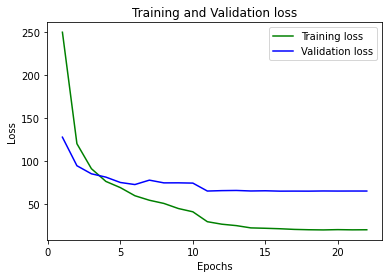

In [164]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,23)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Prikaz kako se mijenjala metrika _MAE_ na train & val setu tijekom učenja modela

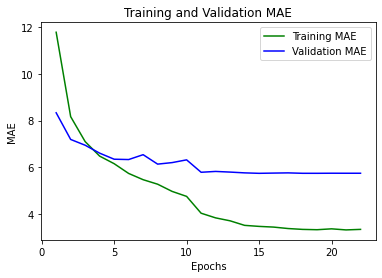

In [165]:
loss_train = history.history['mean_absolute_error']
loss_val = history.history['val_mean_absolute_error']

epochs = range(1,23)

plt.plot(epochs, loss_train, 'g', label='Training MAE')
plt.plot(epochs, loss_val, 'b', label='Validation MAE')

plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Evaluacija modela za regresiju  

Nakon što smo naučili model evaluiramo ga na val i test setu kako bi vidjeli konačne rezultate. \
Praćene metrike su redom: 
- loss
- mean squared error (MSE)
- mean absolute error (MAE)

In [157]:
val_loss, val_MSE, val_MAE = model.evaluate(val_dataset)
test_loss, test_MSE, test_MAE = model.evaluate(test_dataset)

print(val_loss, val_MSE, val_MAE)
print(test_loss, test_MSE, test_MAE)

75/75 [==============================] - 8s 101ms/step - loss: 59.4125 - mean_squared_error: 59.3146 - mean_absolute_error: 5.4444
65.16596984863281 65.06803131103516 5.750237464904785
59.41248321533203 59.31456756591797 5.4444451332092285


#### Spremanje modela na disk 

Model spremamo na disk u prethodno stvoren direktorij na lokaciji definiranoj u varijabli _save_model_root_.

In [24]:
save_model_root = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks'
save_weights_path = os.path.join(save_model_root, 'reg_weights.h5')
save_config_path = os.path.join(save_model_root, 'reg_config.json')
save_model(model, save_weights_path, save_config_path)

## 8. Učenje, evaluacija i spremanje klasifikacijskog modela

Za početak moramo grupirati labele u 5 kategorija po 25 godina (0-25, 25-50, 50-75, 75-100, 100-125) što radimo cjelobrojnim dijeljenjem labela s 25.

Nakon toga pretvaramo np array-eve u tf.Dataset objekte te na kraju pozivamo funkciju _prepare_dataset_ kako bi napravili normalizaciju, augmentaciju i nasumičan odabir. 

In [158]:
# grupiranje labela
grouped_y_train = y_train.astype(np.int32) // 25
grouped_y_val = y_val.astype(np.int32) // 25
grouped_y_test = y_test.astype(np.int32) // 25

# np array --> tf.Dataset
grouped_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, grouped_y_train))
grouped_val_dataset = tf.data.Dataset.from_tensor_slices((X_val, grouped_y_val))
grouped_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, grouped_y_test))

# poziv fukcije prepare_dataset za svaki skup  
grouped_train_dataset = prepare_dataset(grouped_train_dataset, 32, normalization, data_augmentation=data_augmentation, shuffle=True, augment=True)
grouped_val_dataset = prepare_dataset(grouped_val_dataset, 32, normalization)
grouped_test_dataset = prepare_dataset(grouped_test_dataset, 32, normalization)

#### Prikaz raspodjele slika po kategorijama 

18966


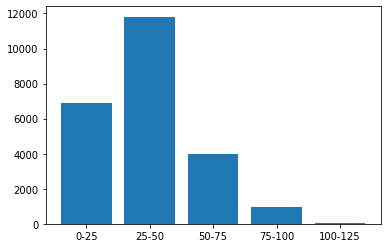


Kategorija  Broj slika

0-25        6903
25-50       11816
50-75       3990
75-100      967
100-125     32


In [16]:
groups = [0]*5
for i in grouped_y_train:
    groups[i] += 1
for i in grouped_y_val:
    groups[i] += 1
for i in grouped_y_test:
    groups[i] += 1
print(len(grouped_y_train))

x = np.array(['0-25', '25-50', '50-75', '75-100', '100-125'] )
y = np.array(groups)

plt.bar(x,y)
plt.show()
print()

print('{0:10}  {1}'.format('Kategorija', 'Broj slika'))
print()
for i in range(0, len(groups)):
    print('{0:10}  {1}'.format(str(str(i*25) + '-' + str((i+1)*25)), groups[i]))

#### Ispis količine podataka po skupovima i kategorijama 

In [20]:
groupsTr = [0]*5
groupsVal = [0]*5
groupsTe = [0]*5
for i in grouped_y_train:
    groupsTr[i] += 1
for i in grouped_y_val:
    groupsVal[i] += 1
for i in grouped_y_test:
    groupsTe[i] += 1
    
 
print("%-20s %-20s %-20s %-20s %-20s" %("Kategorija", "Skup za učenje", "Skup za validaciju", "Skup za testiranje", "Ukupno"))
print()
for i in range(0,5):
    print("%-20s %-20s %-20s %-20s %-20s" %(str(str(i*25) + '-' + str((i+1)*25)), groupsTr[i], groupsVal[i], groupsTe[i], groupsTr[i]+groupsVal[i]+groupsTe[i]))
print()
print("%-20s %-20s %-20s %-20s %-20s" %("Ukupno", len(grouped_y_train), len(grouped_y_val), len(grouped_y_test), len(grouped_y_train)+len(grouped_y_val)+len(grouped_y_test)))

Kategorija      Skup za učenje       Skup za validaciju   Skup za testiranje   Ukupno              

0-25            5558                 666                  679                  6903                
25-50           9425                 1200                 1191                 11816               
50-75           3192                 404                  394                  3990                
75-100          766                  99                   102                  967                 
100-125         25                   2                    5                    32                  

Ukupno          18966                2371                 2371                 23708               


### Izgradnja modela za klasifikaciju 

In [159]:
model2 = Sequential()

model2.add(Conv2D(input_shape=(200, 200, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(LayerNormalization())

model2.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(LayerNormalization())

model2.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(LayerNormalization())

model2.add(Flatten())

model2.add(Dense(units=512, activation='relu'))
model2.add(Dropout(rate=0.1))   

model2.add(Dense(units=512, activation='relu'))
model2.add(Dropout(rate=0.1))   

model2.add(Dense(units=5, activation='softmax')) # izlaz je vektor vjerojatnosti u kojem su vjerojatnosti pripadanja slike svakoj od klasa 

model2.summary()


# zaustavljamo model ako nakon vise od 5 epoha val_accuracy ne bude rastuca funckija 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')

# smanjujemo stopu ucenja kada se val_accuracy prestane poboljsavati
reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, verbose=1, mode='max')

# dodajemo regularizaciju modela 
model2 = add_regularization(model2)

# konfiguriramo model za trening tako da definiramo metriku koju pratimo (accuracy) i optimizator (Adam)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# learning rate (stopa učenja) kontrolira koliko se brzo model prilagođava problemu. 
#  Manje stope učenja zahtijevaju više epoha obuke s obzirom na manje promjene u težinama koje se unose pri svakom ažuriranju, 
#  dok veće stope učenja rezultiraju brzim promjenama i zahtijevaju manje epoha obuke.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 49, 49, 96)        14208     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 96)       0         
 g2D)                                                            
                                                                 
 layer_normalization_24 (Lay  (None, 24, 24, 96)       192       
 erNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 256)       614656    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                     

### Treniranje modela za klasifikaicju 

In [160]:
history2 = model2.fit(grouped_train_dataset, epochs=50, validation_data=grouped_val_dataset, callbacks=[callback, reduce_lr_callback])

Epoch 1/50
593/593 [==============================] - 196s 322ms/step - loss: 1.0758 - accuracy: 0.5859 - val_loss: 1.0674 - val_accuracy: 0.5306 - lr: 5.0000e-05
Epoch 2/50
593/593 [==============================] - 208s 344ms/step - loss: 0.8904 - accuracy: 0.6587 - val_loss: 0.8004 - val_accuracy: 0.6904 - lr: 5.0000e-05
Epoch 3/50
593/593 [==============================] - 216s 357ms/step - loss: 0.7921 - accuracy: 0.6977 - val_loss: 0.7727 - val_accuracy: 0.7162 - lr: 5.0000e-05
Epoch 4/50
593/593 [==============================] - 214s 355ms/step - loss: 0.7256 - accuracy: 0.7275 - val_loss: 0.7262 - val_accuracy: 0.7288 - lr: 5.0000e-05
Epoch 5/50
593/593 [==============================] - 222s 367ms/step - loss: 0.6740 - accuracy: 0.7512 - val_loss: 0.6887 - val_accuracy: 0.7419 - lr: 5.0000e-05
Epoch 6/50
593/593 [==============================] - 226s 375ms/step - loss: 0.6363 - accuracy: 0.7695 - val_loss: 0.7007 - val_accuracy: 0.7326 - lr: 5.0000e-05
Epoch 7/50
593/593 [==

#### Prikaz kako se mijenjala metrika _loss_ na train & val setu tijekom učenja modela 

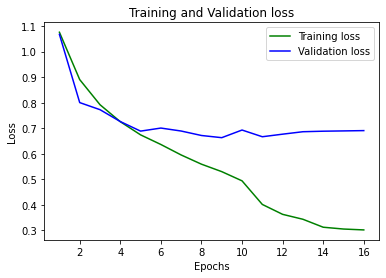

In [161]:
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']

epochs = range(1,17)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Prikaz kako se mijenjala metrika _accuracy_ na train & val setu tijekom učenja modela 

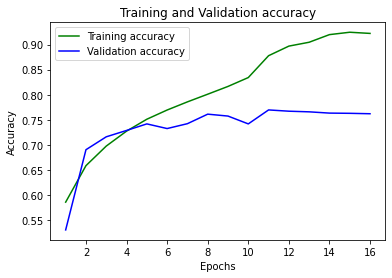

In [175]:
loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']

epochs = range(1,17)

plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluacija modela za klasifikaciju 

Nakon što smo naučili model evaluiramo ga na val i test setu kako bi vidjeli konačne rezultate. \
Praćene metrike su redom: 
- loss
- accuracy

In [166]:
val_loss, val_acc = model2.evaluate(grouped_val_dataset)
test_loss, test_acc = model2.evaluate(grouped_test_dataset)

print(val_loss, val_acc)
print(test_loss, test_acc)

75/75 [==============================] - 8s 105ms/step - loss: 0.6312 - accuracy: 0.7933
0.6666845679283142 0.7697173953056335
0.6311896443367004 0.7933361530303955


#### Spremanje modela na disk 

Model spremamo na disk u prethodno stvoren direktorij na lokaciji definiranoj u varijabli _save_model_root_.

In [142]:
save_model_root = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks'
save_weights_path = os.path.join(save_model_root, 'clf_weights.h5')
save_config_path = os.path.join(save_model_root, 'clf_config.json')
save_model(model2, save_weights_path, save_config_path)

### Prikaz rezultata metrika 

Prikazali smo rezultate sljedećih metrika: 
- precision
- recall 
- f1 score 
- accuracy 
- confusion matrix

Kako bi generirali metrike prvo smo pomoću Kerasove funkcije _predict_ za svaku sliku iz testnog skupa napravili predikciju (pretpostavku dobne skupine kojoj slika pripada) našeg modela te ju spremili u listu y_pred.  
U listu y_true učitali smo stvarne dobne skupine za svaku od slika.

Nakon toga smo pomoću Kerasovih funkcija `precision_score, recall_score, f1_score, accuracy_score i confusion_matrix` te y_pred i y_true generirali rezultate gore navedenih metrika. 

In [179]:
y_true = []
y_pred = []

for x, y_true_batch in grouped_test_dataset:
    y_true_batch = y_true_batch.numpy()
    
    y_probs_batch = model2.predict(x, verbose=0)     # vjerojatnosti za sve klase za svaku sliku 
    y_pred_batch = np.argmax(y_probs_batch, axis=-1) # najvjerojatnija klasa za svaku sliku
    
    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)


precision = precision_score(y_true, y_pred, average=None)
precisionM = precision_score(y_true, y_pred, average='macro')

recall = recall_score(y_true, y_pred, average=None)
recallM = recall_score(y_true, y_pred, average='macro')

f1 = f1_score(y_true, y_pred, average=None)
f1M = f1_score(y_true, y_pred, average='macro')


acc = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

/Users/ninaanic/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninaanic/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
print(f'Precision: {precision} {precisionM}')
print(f'Recall   : {recall} {recallM}')
print(f'F1 score : {f1} {f1M}')
print()
print('Confusion matrix:')
print(conf_mat)

Precision: [0.85084746 0.7905049  0.73138298 0.70512821 0.        ] 0.615572707949099
Recall   : [0.73932253 0.88077246 0.69796954 0.53921569 0.        ] 0.5714560445352465
F1 score : [0.79117415 0.83320095 0.71428571 0.61111111 0.        ] 0.5899543862821034

Confusion matrix:
[[ 502  176    0    1    0]
 [  86 1049   56    0    0]
 [   2   99  275   18    0]
 [   0    3   44   55    0]
 [   0    0    1    4    0]]


### Prikaz augmentiranih slika 

#### Horizaontalno zrcaljenje

Text(0.5, 1.0, 'Horizontalno zrcaljena slika')

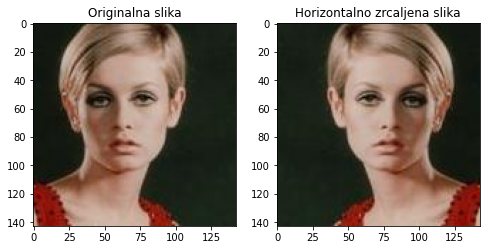

In [58]:
import cv2
img_path = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/206996_1949-09-19_1967.jpg'
image= cv2.imread(img_path)
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flippedimage= cv2.flip(im_rgb, 1)

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(im_rgb)
ax[0].set_title('Originalna slika')

ax[1].imshow(flippedimage)
ax[1].set_title('Horizontalno zrcaljena slika')

#### Promjena svjetline

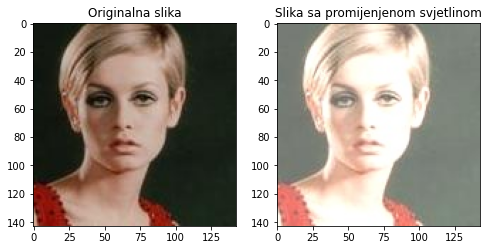

In [2]:
import cv2
import matplotlib.pyplot as plt 
img_path1 = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/206996_1949-09-19_1967.jpg'
img_path2 = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/output.jpg'
image1= cv2.imread(img_path1)
im_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2= cv2.imread(img_path2)
im_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(im_rgb1)
ax[0].set_title('Originalna slika')

ax[1].imshow(im_rgb2)
ax[1].set_title('Slika sa promijenjenom svjetlinom')


def fast_brightness(input_image, brightness):
    ''' input_image:  color or grayscale image
        brightness:  -255 (all black) to +255 (all white)

        returns image of same type as input_image but with
        brightness adjusted'''
    img = input_image.copy()
    cv2.convertScaleAbs(img, img, 1, brightness)
    return img

#img = cv2.imread(img_path,cv2.IMREAD_COLOR)
#cv2.imwrite('output.jpg', fast_brightness(img, 100))

#### Promjena kontrasta

Text(0.5, 1.0, 'Slika sa promijenjenim kontrastom')

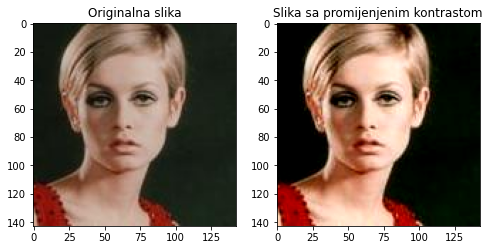

In [4]:
from PIL import Image, ImageEnhance

#read the image
img_path1 = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/206996_1949-09-19_1967.jpg'
image1= cv2.imread(img_path1)

im = Image.open(img_path1)
enhancer = ImageEnhance.Contrast(im)

factor = 1 
im_output = enhancer.enhance(factor)
im_output.save('original-image.png')

factor = 0.5 #decrease constrast
im_output = enhancer.enhance(factor)
im_output.save('less-contrast-image.png')

factor = 1.5 #increase contrast
im_output = enhancer.enhance(factor)
im_output.save('more-contrast-image.png')

img_path1 = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/206996_1949-09-19_1967.jpg'
img_path2 = '/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/more-contrast-image.png'
image1= cv2.imread(img_path1)
im_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2= cv2.imread(img_path2)
im_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(im_rgb1)
ax[0].set_title('Originalna slika')

ax[1].imshow(im_rgb2)
ax[1].set_title('Slika sa promijenjenim kontrastom')
